In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
columns = ['X','Y','month','day','FFMC','DMC','DC','ISI','temp','RH','wind','rain']

df = pd.read_csv(uploaded)
df[['day','month']] = OrdinalEncoder().fit_transform(df[['day','month']])

#scale independent variables
df[columns]=StandardScaler().fit_transform(df[columns])

# z = np.abs(zscore(df))
# df = df[(z < 3).all(axis=1)]

# print(df.shape)
# df.head()

In [3]:
X_orig = df[columns]
y = df['area']
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
skewness,0.036246,0.417296,0.084074,0.157756,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344,12.846934
kurtosis,-1.172331,1.420553,-1.719350,-1.101004,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964,194.140721


In [4]:
outliers = LocalOutlierFactor(20).fit_predict(X_orig)
target_out = LocalOutlierFactor(20).fit_predict(y.values.reshape(-1,1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X_orig,y=X_orig[outliers],y[outliers]
X_orig.shape

(483, 12)

In [5]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_orig.values, i) for i in range(X_orig.shape[1])]
vif["features"] = X_orig.columns
vif

,VIF Factor,features
0,1.400216,X
1,1.412978,Y
2,1.522731,month
3,1.062672,day
4,2.818760,FFMC
5,2.792247,DMC
6,2.857340,DC
7,2.381729,ISI
8,2.888902,temp
9,1.915021,RH


In [6]:
X = X_orig[:]

In [7]:
k=X.shape[1]

acc_metric = 'neg_mean_squared_error'
# acc_metric = 'neg_mean_absolute_error'

cv = KFold(n_splits=10, shuffle= True,random_state=100)

model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])

X.shape

(483, 12)

In [8]:
# Dimash's version
# def get_soc(final_clf, features):
#     soc = 0
#     n = 7     # for tanh
#     if( final_clf.get_params()['activation'] == 'relu' ):
#       n = 1
#     elif ( final_clf.get_params()['activation'] == 'logistic' ):
#       n = 3

#     for i in final_clf.get_params()['hidden_layer_sizes']:
#       soc += ( 2 * features + n * i )
#       features = i
#     soc += 2 * features * final_clf.n_outputs_
#     return soc

In [31]:
# Prof's version
def get_soc(clf, P):
    soc=0
    ac=clf.get_params()['activation']
    At = (ac=='relu')*1 + (ac=='logistic')*4 + (ac=='tanh') * 9
    N = list(clf.get_params()['hidden_layer_sizes'])
    N.insert(0,P)
    H = len(N)
    N.append(clf.n_outputs_)
    
    for h in range(H):
        soc += (2 * N[h] + At) * N[h+1] + 2*N[h+1]
    return soc

In [32]:
arr_mse = []
arr_mae = []
arr_soc = []
arr_hls = []

In [33]:
def test(params, cv=5, N=10, scoring='neg_mean_absolute_error'):
    socs=[]
    maes=[]
    h_layers=[]
    for _ in range(N):
        grid = GridSearchCV(MLPRegressor(), param_grid = params, cv=cv, scoring=scoring)
        grid.fit(X, y)
        final_clf = grid.best_estimator_
        mae = cross_val_score(final_clf,X,y,cv=cv,scoring=scoring)
        mae = np.abs(np.mean(mae))
        soc=get_soc(final_clf, X.shape[1])
        socs.append(soc)
        maes.append(mae)
        h_layers.append((final_clf.get_params()['activation'],final_clf.get_params()['hidden_layer_sizes']))
    return maes,socs,h_layers

In [34]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_6 = {
 'activation': ['logistic'], 
 'hidden_layer_sizes': [(27,)], 
 'learning_rate_init': [0.01]
}
maes,socs,params=test(params_6,cv,5)
print(np.mean(maes))
maes,socs,params
# clf = MLPRegressor()
# grid = GridSearchCV(clf, param_grid = params_6, cv=5, scoring='neg_mean_absolute_error')
# grid.fit(X, y)

# print("Best Hyperparameters::\n{}".format(grid.best_params_))
# results = pd.DataFrame(data=grid.cv_results_)

# final_clf = grid.best_estimator_

# _,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

# mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
# mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

# std = np.std(mse)
# mse = np.abs(np.mean(mse))
# mae = np.abs(np.mean(mae))
# soc=get_soc(final_clf, 12)

# arr_mse.append(mse)
# arr_mae.append(mae)
# arr_soc.append(soc)
# arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
# print("mae : ", mae)
# print("soc : ", soc)


7.026539175563883


([7.041089236449054,
  6.974601828456288,
  7.03632388863516,
  7.0622481192439235,
  7.018432805034993],
 [870, 870, 870, 870, 870],
 [('logistic', (27,)),
  ('logistic', (27,)),
  ('logistic', (27,)),
  ('logistic', (27,)),
  ('logistic', (27,))])

In [48]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_1 = {
 'activation': ['logistic'], 
 'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)], 
 'learning_rate_init': [0.000166810]
}
maes,socs,params=test(params_1,cv,5)
print(np.mean(maes))
maes,socs,params

6.192751715637935


([6.228502255921419,
  6.205460869389868,
  6.198729947066687,
  6.12955138482356,
  6.201514120988142],
 [2206, 2206, 2206, 2206, 2206],
 [('logistic', (100,)),
  ('logistic', (100,)),
  ('logistic', (100,)),
  ('logistic', (100,)),
  ('logistic', (100,))])

In [49]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_2 = {
 'activation': ['logistic'], 
 'hidden_layer_sizes': [(30,)], 
 'learning_rate_init': [0.0001668100]
}
maes,socs,params=test(params_2,cv,10)
print(np.mean(maes))
maes,socs,params

5.472950765468303


([5.466371080750027,
  5.494207546482855,
  5.48177754209171,
  5.484212167677513,
  5.5015359681389935,
  5.443613550379962,
  5.503322751640862,
  5.45824290735447,
  5.453733517362029,
  5.442490622804604],
 [666, 666, 666, 666, 666, 666, 666, 666, 666, 666],
 [('logistic', (30,)),
  ('logistic', (30,)),
  ('logistic', (30,)),
  ('logistic', (30,)),
  ('logistic', (30,)),
  ('logistic', (30,)),
  ('logistic', (30,)),
  ('logistic', (30,)),
  ('logistic', (30,)),
  ('logistic', (30,))])

Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.0001}


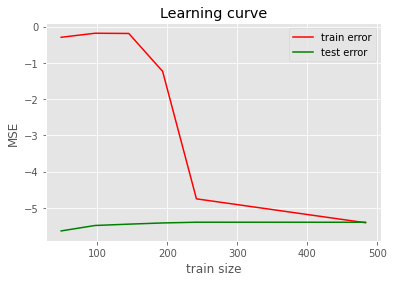

mse :  136.4468261038399
mae :  5.376028261103217
soc :  806


In [63]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_3 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(25,),(50,),(75)],
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_3, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (15,), 'learning_rate_init': 0.0001}


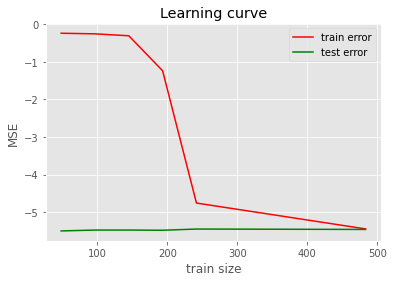

mse :  140.92745715434063
mae :  5.434847131948777
soc :  486


In [51]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_4 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(25,), (35,), (15,)],
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_4, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.0001}


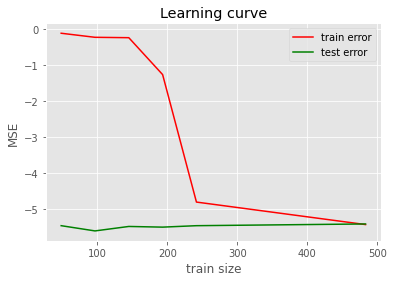

mse :  140.19572245573733
mae :  5.534287938556427
soc :  646


In [52]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_5 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(20,), (30,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_5, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)




Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (28,), 'learning_rate_init': 0.0001668100537200059}


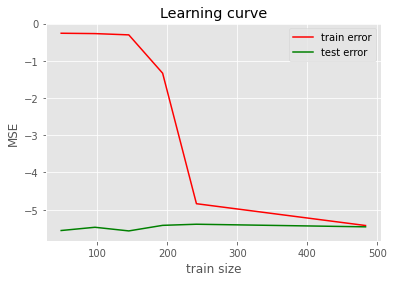

mse :  136.96565160794344
mae :  5.481597055793347
soc :  815


In [64]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params_6 = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(26,),(27,),(28,),(29,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params_6, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [54]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(10,),(5,5), (5,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

# plt.title("Learning curve")
# plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
# plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
# plt.legend()
# plt.xlabel('train size')
# plt.ylabel('MSE')
# plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
# mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
# mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

# arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
# print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)






Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (5, 5), 'learning_rate_init': 0.000774263682681127}
mae :  5.635460434485935
soc :  246


Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.000774263682681127}


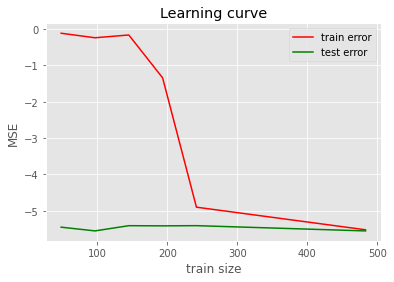

mse :  131.02574601881284
mae :  5.502957483604366
soc :  166


In [70]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(3,3), (5,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.0001668100537200059}


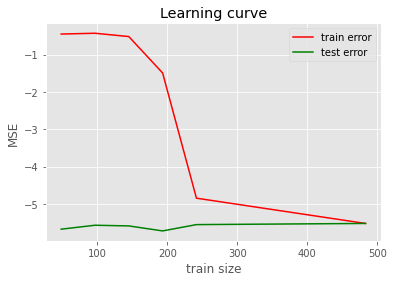

mse :  142.951201326594
mae :  5.616736731003991
soc :  70


In [74]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(2,),(4,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)

Best Hyperparameters::
{'activation': 'logistic', 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.002154434690031882}


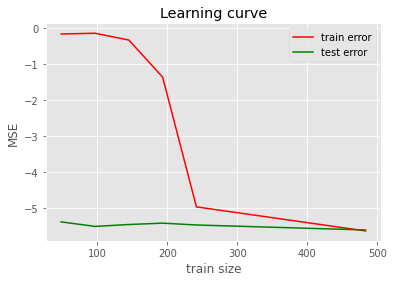

mse :  129.7195902663907
mae :  5.848530493416079
soc :  38


In [82]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['logistic', 'tanh', 'relu'], 
 'hidden_layer_sizes': [(1,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


Best Hyperparameters::
{'activation': 'relu', 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.0001}


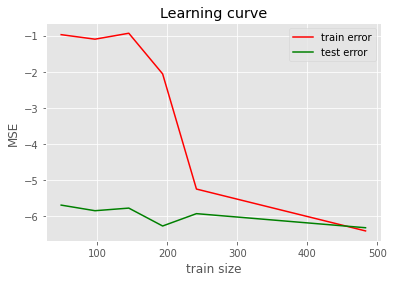

mse :  147.1202734123903
mae :  5.802936731702127
soc :  32


In [58]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['relu'], 
 'hidden_layer_sizes': [(1,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 12)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [59]:
from sklearn.feature_selection import SelectKBest, f_regression

X = SelectKBest(f_regression, k=8).fit_transform(X_orig, y)

Best Hyperparameters::
{'activation': 'tanh', 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.002154434690031882}


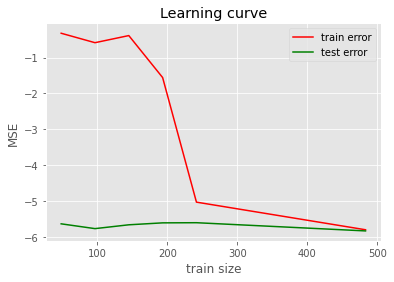

mse :  125.95479166961427
mae :  5.7901403845223935
soc :  40


In [60]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['tanh'], 
 'hidden_layer_sizes': [(1,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 8)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [61]:
from sklearn.feature_selection import SelectKBest, f_regression

X = SelectKBest(f_regression, k=7).fit_transform(X_orig, y)

Best Hyperparameters::
{'activation': 'tanh', 'hidden_layer_sizes': (1,), 'learning_rate_init': 0.00046415888336127773}


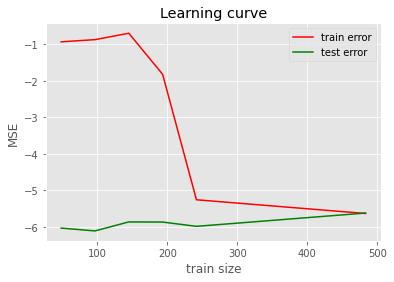

mse :  145.61909191609283
mae :  5.707923537070342
soc :  38


In [62]:
# default learning_rate_init = 0.001
# default hidden_layer_sizes = (100, )
params = {
 'activation': ['tanh'], 
 'hidden_layer_sizes': [(1,)], 
 'learning_rate_init': np.logspace(-4,-2, 10)
}

clf = MLPRegressor()
grid = GridSearchCV(clf, param_grid = params, cv=5, scoring='neg_mean_absolute_error')
grid.fit(X, y)

print("Best Hyperparameters::\n{}".format(grid.best_params_))
results = pd.DataFrame(data=grid.cv_results_)

final_clf = grid.best_estimator_

_,train_scores,test_scores=learning_curve(final_clf,X,y,cv=cv,train_sizes=train_sizes,scoring='neg_mean_absolute_error')

plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-',label='train error')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-',label='test error')
plt.legend()
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

mse = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_squared_error')
mae = cross_val_score(final_clf,X,y,cv=10,scoring='neg_mean_absolute_error')

std = np.std(mse)
mse = np.abs(np.mean(mse))
mae = np.abs(np.mean(mae))
soc=get_soc(final_clf, 7)

arr_mse.append(mse)
arr_mae.append(mae)
arr_soc.append(soc)
arr_hls.append(final_clf.get_params()['hidden_layer_sizes'])
print("mse : ", mse)
print("mae : ", mae)
print("soc : ", soc)


In [20]:
arr_mae, arr_soc

([5.450285664453615,
  5.660398930960683,
  5.434134945359537,
  5.476933649870999,
  5.742093960539892],
 [56, 56, 53, 36, 5])

In [ ]:
arr_mae_min = [5.150434560004236]
arr_soc_min = [159]
arr_mae_min_soc = [5.575807878266114]
arr_soc_min_soc = [25]

In [ ]:
arr_mae_not_allowed = [ x for x in arr_mae if x >= arr_mae_min[0]*1.1 ]
arr_mae_not_allowed

[5.779896030997618, 5.746831712466329]

In [ ]:
arr_mae_not_allowed_soc = [27, 23]

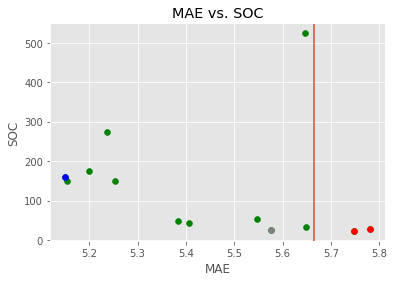

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, [25], c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

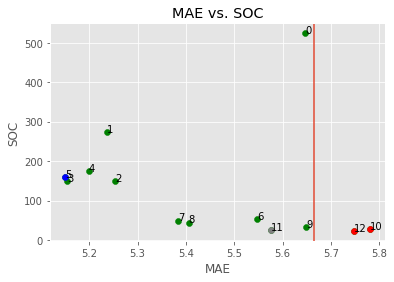

In [ ]:
plt.title("MAE vs. SOC")

plt.scatter(arr_mae, arr_soc, c='green')
plt.scatter(arr_mae_not_allowed, arr_mae_not_allowed_soc, c='red')
plt.scatter(arr_mae_min, arr_soc_min, c='blue')
plt.scatter(arr_mae_min_soc, [25], c='grey')
plt.axvline(x=arr_mae_min[0]*1.1)

for i, txt in enumerate(arr_mae):
    plt.annotate(i, (arr_mae[i], arr_soc[i]))

plt.xlabel('MAE')
plt.ylabel('SOC')
plt.show()

In [ ]:
activation = [ 'logistic','logistic','logistic','logistic','logistic','logistic', 'relu', 'logistic', 'logistic', 'tanh', 'relu', 'tanh', 'tanh' ]

In [ ]:
data = { 'MAE': arr_mae, 'SOC': arr_soc, 'Hidden Layer Size ': arr_hls, 'activation': activation }
df = pd.DataFrame(data)
df

,MAE,SOC,Hidden Layer Size,activation
0,5.646260,524,"(100,)",logistic
1,5.236420,274,"(50,)",logistic
2,5.253535,149,"(25,)",logistic
3,5.153624,149,"(25,)",logistic
4,5.198886,174,"(30,)",logistic
5,5.150435,159,"(27,)",logistic
6,5.547325,54,"(10,)",relu
7,5.382948,49,"(5,)",logistic
8,5.405279,44,"(4,)",logistic
9,5.649007,33,"(1,)",tanh
